In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import corruptions
import models

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=3

In [0]:
def show(x):
    x = np.array(x)
    plt.imshow(x, cmap='gray')
    plt.show()
    
train_mnist = datasets.MNIST("../data/", train=True, transform=transforms.ToTensor())
test_mnist = datasets.MNIST("../data/", train=False, transform=transforms.ToTensor())
IMAGES = [test_mnist[i][0] for i in range(50)]
LABELS = [test_mnist[i][1] for i in range(50)]
to_pil = transforms.ToPILImage()
device = torch.device("cuda")
cpu = torch.device("cpu")

In [0]:
def normalize(tensor, mean=(0.1307,), std=(0.3081,)):
    mean = torch.as_tensor(mean, dtype=torch.float32, device=tensor.device)
    std = torch.as_tensor(std, dtype=torch.float32, device=tensor.device)
    return tensor.sub(mean[:, None, None]).div(std[:, None, None])

def main(model, epochs, lr, momentum, sgd, batch_size, targeted, adv_target, test_batch_size, log_interval, eps, lam):

    def train(model, A, device, train_loader, optimizer, epoch):
        model.eval()
        for batch_idx, (data, target) in enumerate(train_loader):
            A.requires_grad = True
            data, target = data.to(device), target.to(device)
            noise = torch.normal(mean=torch.zeros(batch_size, 1, 196)).to(device) @ A
            norm = noise.norm(dim=-1)
            scaled_noise = (noise.transpose(0, -1) / norm.squeeze()).transpose(0, -1) * eps / 4
            tiled_noise = scaled_noise.view(batch_size, 1, 14, 14).repeat(1, 1, 2, 2)
            data = data + tiled_noise.view(data.shape)
            data = normalize(torch.clamp(data, 0, 1))
            optimizer.zero_grad()
            output = model(data)
            if targeted:
                loss = -F.nll_loss(output, target) + F.nll_loss(output, adv_target)
            else:
                loss = -F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
            A.detach_()


    def test(model, A, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                noise = torch.normal(mean=torch.zeros(test_batch_size, 1, 196)).to(device) @ A
                norm = noise.norm(dim=-1)
                scaled_noise = (noise.transpose(0, -1) / norm.squeeze()).transpose(0, -1) * eps / 4
                tiled_noise = scaled_noise.view(test_batch_size, 1, 14, 14).repeat(1, 1, 2, 2)
                data = data + tiled_noise.view(data.shape)
                data = normalize(torch.clamp(data, 0, 1))
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    
    device = torch.device("cuda")
    cpu = torch.device("cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                        transform=transforms.ToTensor()),
        batch_size=test_batch_size, shuffle=True, pin_memory=True)

    A = torch.eye(196).to(device)
    A.requires_grad = True
    
    if targeted:
        adv_target = torch.tensor([adv_target]).repeat(batch_size).to(device)

    model = model()
    
    if sgd:
        optimizer = optim.SGD([A], lr=lr, momentum=momentum)
    else:
        optimizer = optim.Adam([A])
    
    for epoch in range(1, epochs + 1):
        if epoch in [45, 90]:
            new_lr = lr * (0.1 ** (epoch // 30))
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr
        train(model, A, device, train_loader, optimizer, epoch)
        test(model, A, device, test_loader)
        
    return A

In [0]:
A = main(model=models.ConvNet, epochs=135, lr=1000., momentum=0., sgd=True, batch_size=100,
         targeted=False, adv_target=8, test_batch_size=1000, log_interval=100, eps=10.63, lam=0.)

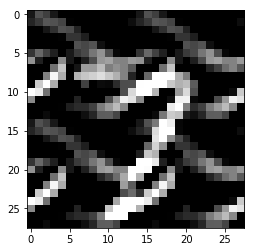

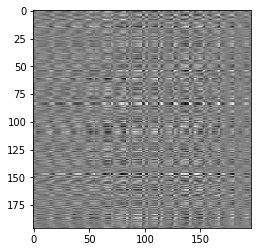

In [0]:
noise = torch.normal(mean=torch.zeros(1, 1, 196)) @ A.to(cpu)
norm = noise.norm(dim=-1)
scaled_noise = (noise.transpose(0, -1) / norm.squeeze()).transpose(0, -1) * 10.63 / 4
tiled_noise = scaled_noise.view(1, 1, 14, 14).repeat(1, 1, 2, 2)
x = IMAGES[0] + tiled_noise.view(IMAGES[0].shape)
x = torch.clamp(x, 0, 1)
show(x[0])
x = A.to(cpu).view(196, 196)
plt.imshow(np.array(x), cmap="gray")

In [0]:
final = A.detach().cpu().numpy()
torch.save(final, "pessimal_noise_matrix")